In [1]:
## Load libraries

import pandas as pd
import numpy as np
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import MultiLabelBinarizer


%load_ext autoreload
%autoreload 2

In [2]:
og_glove_file = r"/Users/anshuman/UMass/CS 682/Project/glove.6B/glove.6b.300d.txt" ## glove text file that you download from internet, 6b words 300d,
new_glove_file =r"glove6b300d.bin"
movie_data_file =r"ml-1m/movies.dat" #movie data file
user_data_file =r"ml-1m/users.dat" #user data file
rating_data_file = r"ml-1m/ratings.dat" #rating data file

In [3]:
##Run this only once ever, if you have skip this and go to the next cell
## Insert your glove location below.
## This is done to convert .txt glove to binary format for easier loading.
glove_file = datapath(og_glove_file)
tmp_file = get_tmpfile("glove.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)
model.save_word2vec_format(new_glove_file,binary=True)

In [4]:
 ##load binary glove model
glove_model = gensim.models.KeyedVectors.load_word2vec_format(new_glove_file,binary=True)
##get vocabulary
vocab = list(glove_model.wv.vocab.keys())

/Users/anshuman/anaconda3/envs/cs682/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [5]:
## loading the dataset into dataframes

movieData = pd.read_csv(movie_data_file,sep="::",names=["MovieID","Name","Genres"],engine='python')
userData = pd.read_csv(user_data_file,sep="::",names=["UserID","Gender","Age","Occupation","Zipcode"],engine='python')
ratingData = pd.read_csv(rating_data_file,sep="::",names=["UserID","MovieID","Rating","Timestamp"],engine='python')


In [6]:
## movie data preprocessing  - getting a dictionary of movie name and id pairs,
##creating genrelist, and reseting movieData dataframe

movieNameData = movieData["Name"].unique()
movieNameDict = {movieNameData[i]:i for i in range(0,movieNameData.shape[0])}
genreList = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
              "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
genres = movieData["Genres"].apply(lambda x : x.split("|"))
movieData.reset_index(inplace=True,drop=True)


In [7]:
from data_preparation import MovieEncodingEmbedding

print(movieData.shape)
numRows = movieData.shape[0]
# print(movieData, movieData.loc[0][0], movieData.loc[0][1], movieData.loc[0][2])
movie_embeddings = np.zeros((3953, 318))

# Prepare movie embeddings -> A Mapping from MovieID to its embedding. This can then be used during model training
for rowNum in range(numRows):
    movieID = movieData.loc[rowNum]['MovieID']
#     print(rowNum, movieID)
    movie_embeddings[movieID] = MovieEncodingEmbedding(movieID, movieData, genreList, glove_model, vocab)

print("Movie Embeddings", movie_embeddings.shape)

(3883, 3)
Movie Embeddings (3953, 318)


In [8]:
from data_preparation import UserSequences

## get user Sequences
userSequences = UserSequences(ratingData,-1)

27


In [9]:
print(len(userSequences))
print(len(userSequences[0]))
print(userSequences[99][1])

5421
27
(3873,)


In [10]:
## get user-movie encodings for the data with embedding flag false and write it to file.
## In every file each line will contain
##userid::gender::userDataAge::userDataOccupation::userDataZipCode::movieid::(one hot genre encoding of len 18[each separated by ::]):rating 
# data = UserMoviePairEncodingBatch(userSequences,False)

# with open("usermovie.dat","w") as f:
#     for i in range(len(data)):
#         for j in range(data[i].shape[0]):
#             f.write("::".join(data[i][j]))
#             f.write("\n")
                 

In [11]:
## get user-movie encodings for the data with embedding flag false and write it to file.
## In every file each line will contain
##userid::gender::userDataAge::userDataOccupation::userDataZipCode::(movieid_embedding[len 300, separated by ::])::(one hot genre encoding of len 18[each separated by ::]):rating 

# data = UserMoviePairEncodingBatch(userSequences,True)

# with open("usermoviembeddings.dat","w") as f:
#     for i in range(len(data)):
#         for j in range(data[i].shape[0]):
#             f.write("::".join(data[i][j]))
#             f.write("\n")

In [12]:
# np.array(data).shape
# print ("data", len(data), data[0].shape)
from sklearn.model_selection import train_test_split

def fix(data):
    newData = np.empty(data.shape, dtype=int)
    for i, userSeq in enumerate(data):
        for j, tup in enumerate(userSeq):
            newData[i][j] = tup[0]
    return newData

data = fix(np.array(userSequences))
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

train_inp = movie_embeddings[train_data[:, :-1]]
train_tgt = train_data[:, 1:]

test_inp = movie_embeddings[test_data[:, :-1]]
test_tgt = test_data[:, 1:]

val_inp = movie_embeddings[val_data[:, :-1]]
val_tgt = val_data[:, 1:]

print ("train", train_data.shape, train_inp.shape, train_tgt.shape)
print ("val", val_data.shape, val_inp.shape, val_tgt.shape)
print ("test", test_data.shape, test_inp.shape, test_tgt.shape)            

train (3468, 27) (3468, 26, 318) (3468, 26)
val (868, 27) (868, 26, 318) (868, 26)
test (1085, 27) (1085, 26, 318) (1085, 26)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

In [15]:
# train_data = batchify(torch.Tensor(train_data), 10)
# val_data = batchify(torch.Tensor(val_data), 10)
# test_data = batchify(torch.Tensor(test_data), 10)

train_data_final = torch.Tensor(train_inp)
val_data_final = torch.Tensor(val_inp)
test_data_final = torch.Tensor(test_inp)

train_tgt_final = torch.Tensor(train_tgt).long()
val_tgt_final = torch.Tensor(val_tgt).long()
test_tgt_final = torch.Tensor(test_tgt).long()

print("Train", train_data_final.shape, train_tgt_final.shape)
print("Val", val_data_final.shape, val_tgt_final.shape)
print("Test", test_data_final.shape, test_tgt_final.shape)

Train torch.Size([3468, 26, 318]) torch.Size([3468, 26])
Val torch.Size([868, 26, 318]) torch.Size([868, 26])
Test torch.Size([1085, 26, 318]) torch.Size([1085, 26])


In [21]:
import time
import math
from model import RNNModel
from learner import Learner

device = "cpu"

_, temporal_batch_size, input_size = train_data_final.shape
ntokens = 3953
nlayers = 2
hidden_size = 100
dropout = 0.7
train_batch_size = 50
val_batch_size = val_data_final.shape[0]
test_batch_size = test_data_final.shape[0]

model = RNNModel('gru', ntokens, input_size, hidden_size, nlayers, dropout)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5)
optimizer = optim.SGD(model.parameters(), lr=10)
learner = Learner(model, criterion, optimizer)

best_val_loss = None
num_epochs = 25

# Loop over epochs.
for epoch in range(1, num_epochs+1):
    print ("| epoch {:3d} |".format(epoch))
    epoch_start_time = time.time()
    learner.train(train_data_final, train_tgt_final, ntokens, train_batch_size)
    val_loss = learner.evaluate(val_data_final, val_tgt_final, ntokens, val_batch_size)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | val loss {:5.2f} '
          .format(epoch, (time.time() - epoch_start_time),
                                       val_loss))
    print('-' * 89)
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open("model.pt", 'wb') as f:
            torch.save(model.state_dict(), f)
        best_val_loss = val_loss
#     else if lr > 1e-3:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
#         lr /= 1.5

| epoch   1 |
   20/   70 batches  | loss  7.67
   40/   70 batches  | loss  7.49
   60/   70 batches  | loss  7.40
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  8.72s | val loss  7.06 
-----------------------------------------------------------------------------------------
| epoch   2 |
   20/   70 batches  | loss  7.12
   40/   70 batches  | loss  7.11
   60/   70 batches  | loss  7.11
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  8.70s | val loss  7.01 
-----------------------------------------------------------------------------------------
| epoch   3 |
   20/   70 batches  | loss  7.06
   40/   70 batches  | loss  7.06
   60/   70 batches  | loss  7.07
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  8.73s | val loss  7.01 
----------------------------------------------

   20/   70 batches  | loss  6.93
   40/   70 batches  | loss  6.94
   60/   70 batches  | loss  6.95
-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  8.96s | val loss  6.98 
-----------------------------------------------------------------------------------------


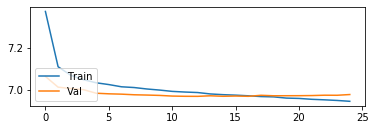

In [22]:
learner.plotLearningCurve()

In [27]:
model = RNNModel('gru', ntokens, input_size, hidden_size, nlayers, dropout)
model.load_state_dict(torch.load("model.pt"))
model.eval()
generator = Learner(model, criterion, optimizer)

In [38]:
generated_seq = learner.generate_seq (3000, movie_embeddings, 10)
print("Generated Sequence:")
for id in generated_seq:
    print(movieData.loc[movieData["MovieID"]==id])

Generated Sequence:
      MovieID                                           Name  \
2931     3000  Princess Mononoke, The (Mononoke Hime) (1997)   

                          Genres  
2931  Action|Adventure|Animation  
      MovieID                Name                  Genres
2502     2571  Matrix, The (1999)  Action|Sci-Fi|Thriller
      MovieID                     Name  Genres
3878     3948  Meet the Parents (2000)  Comedy
    MovieID           Name          Genres
15       16  Casino (1995)  Drama|Thriller
     MovieID                           Name             Genres
770      780  Independence Day (ID4) (1996)  Action|Sci-Fi|War
      MovieID                             Name    Genres
1229     1249  Nikita (La Femme Nikita) (1990)  Thriller
      MovieID                         Name            Genres
1214     1233  Boat, The (Das Boot) (1981)  Action|Drama|War
    MovieID                  Name  Genres
99      101  Bottle Rocket (1996)  Comedy
     MovieID            Name        Gen

In [40]:
test_loss = learner.evaluate(test_data_final, test_tgt_final, ntokens, test_batch_size)
print("Test Loss: ", test_loss)

Test Loss:  6.996011734008789
